# 1. Prepare

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import math
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread, imsave, figure
import pandas as pd
import numpy as np
import sys
import os
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
import seaborn as sns

#Keras:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

#Custom Functions:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from imports.utils.log_progress import log_progress
from imports.utils.visualization import Visualize, Evaluate
from imports.models.data_generator import DataGenerator
from imports.utils.enums import DATA_BASE_PATH, SHAPE
from imports.models.u_net import get_unet, get_unet_mod
from imports.models.u_net import UNet
from imports.utils.utils import rle_encode, rle_decode

DATA_IMAGE_PATH = DATA_BASE_PATH + '/Images'
DATA_MASK_PATH = DATA_BASE_PATH + '/Masks'

SHAPE = (512,768)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [3]:
import warnings
warnings.filterwarnings("ignore")

### Check if GPU available:

In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Read Dataframes:

In [5]:
df = pd.read_pickle(DATA_BASE_PATH+"/df")
df.head(1)

image_path              mask_path  \
0  ../data/00_all/images/  ../data/00_all/masks/   

                mask_cirlce_path          name dataset  \
0  ../data/00_all/masks_autogen/  img_1000.png    None   

                                            mask_rle  \
0  773 253 1061 130 2308 255 2596 131 3845 254 41...   

                                     mask_circle_rle  \
0  210163 81 214744 135 219334 171 223927 201 228...   

                                       roots  \
0  [[947.6608444830582, 198.98217169159952]]   

                                             splines  
0  [[[650.1494324934839, 103.97898089758343], [72...

### Load Splited Data

In [6]:
train_df = pd.read_pickle(DATA_BASE_PATH+'/train_df')
val_df = pd.read_pickle(DATA_BASE_PATH+'/val_df')

print("Number of training Samples:", len(train_df))
print("Number of validation Samples:", len(val_df))

Number of training Samples: 405
Number of validation Samples: 102


In [7]:
train_df.sample(1)

image_path              mask_path  \
33  ../data/00_all/images/  ../data/00_all/masks/   

                 mask_cirlce_path          name dataset  \
33  ../data/00_all/masks_autogen/  img_1163.png    None   

                                             mask_rle  \
33  423026 9 423343 4 424561 13 424575 6 424875 11...   

                                      mask_circle_rle  \
33  1555144 81 1559725 135 1564315 171 1568908 201...   

                                                roots  \
33  [[762.6019808861859, 490.73573855005753], [686...   

                                              splines  
33  [[[514.2051141615985, 609.4989403912543], [555...

# 3 Training:

### 3.1 Load UNet Model:

Vanilla UNet:

In [54]:
model = get_unet_mod(input_shape=(*SHAPE,3),feature_maps=[8,16,32,64,128,256,512],num_classes=2)

In [55]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 512, 768, 3)  0                                            
__________________________________________________________________________________________________
coordinate_channel2d_2 (Coordin (None, 512, 768, 5)  0           input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_193 (Conv2D)             (None, 512, 768, 8)  368         coordinate_channel2d_2[0][0]     
__________________________________________________________________________________________________
batch_normalization_75 (BatchNo (None, 512, 768, 8)  32          conv2d_193[0][0]                 
__________________________________________________________________________________________________
activation

In [8]:
from keras.applications.resnet_v2 import ResNet50V2

In [8]:
unet = UNet()
unet.create_pretrained_model(batchnorm=True,coord_conv=False)
model = unet.get_model()
unet.freeze_encoder(model)
model = unet.get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 768, 3)  0                                            
__________________________________________________________________________________________________
d10 (Conv2D)                    (None, 512, 768, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 768, 64) 256         d10[0][0]                        
__________________________________________________________________________________________________
d11 (Conv2D)                    (None, 512, 768, 64) 36928       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [44]:
from keras.utils import plot_model
plot_model(model, show_shapes=True,to_file='model.png')

Pretrained UNet:

In [62]:
from segmentation_models import Unet, PSPNet
from segmentation_models.losses import bce_jaccard_loss, dice_loss
from segmentation_models.metrics import iou_score
model = Unet("vgg19",input_shape=(512,768,3),encoder_weights="imagenet",freeze_encoder=True,classes=2)
#model.compile("Adam",loss=bce_jaccard_loss,metrics=[iou_score,dice_loss])

In [63]:
from keras.utils import plot_model
plot_model(model, show_shapes=True,to_file='model2.png')

In [64]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 512, 768, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 768, 64) 1792        input_18[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 768, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 384, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

### 3.2 Define Train- Generator:

In [9]:
params = {'target_size': SHAPE,
          'batch_size': 4,
          'input_channels': 3,
          'shuffle': True}

# Generators
sample_gen = DataGenerator(df=train_df,hist_equal=True,augment_data=True,save_images=False,**params)
i_sample = iter(sample_gen)

Found 405 Files


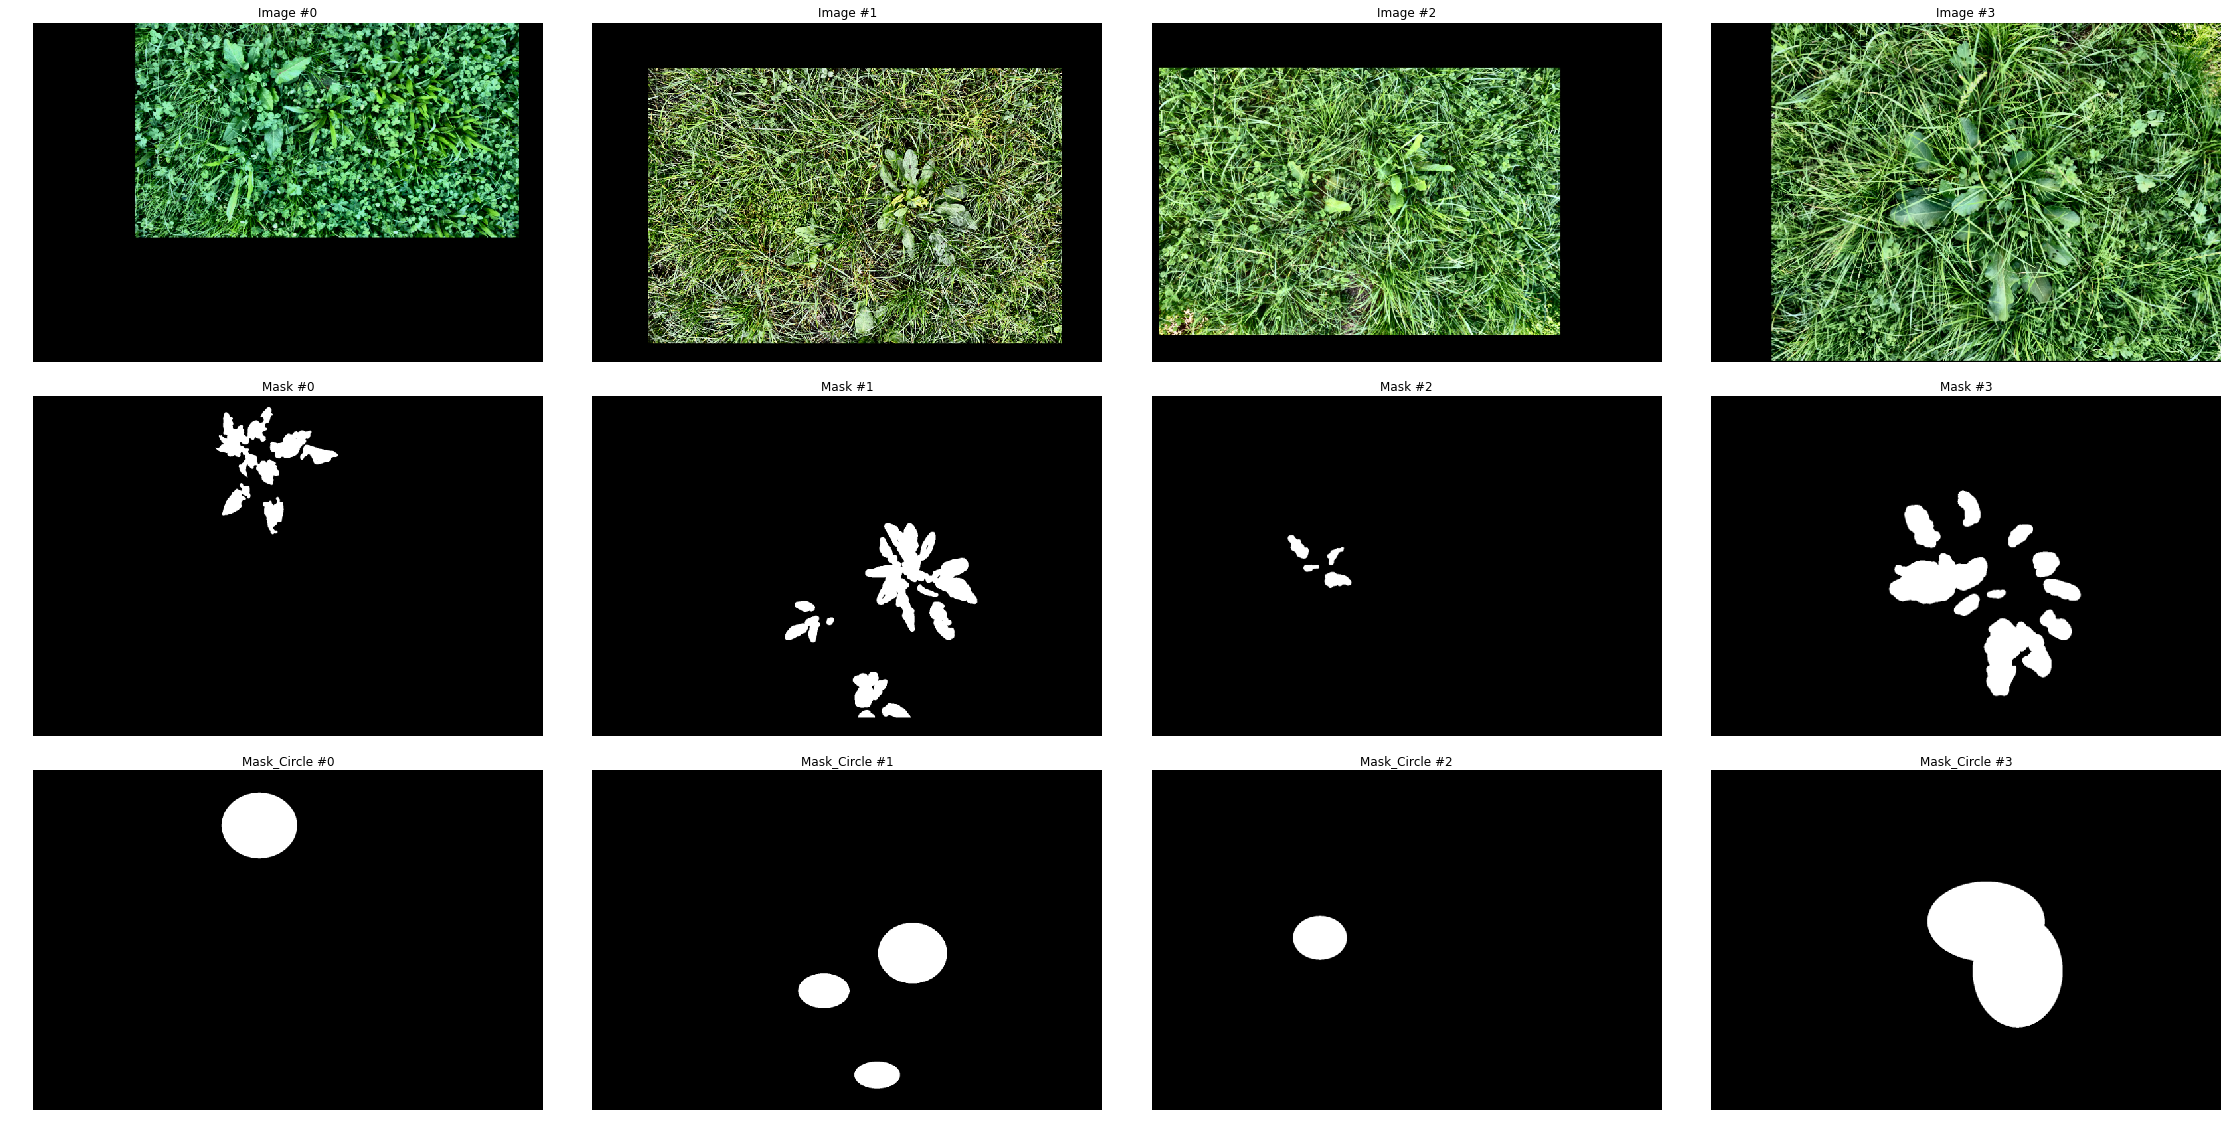

In [10]:
imgs,msks = next(i_sample)
plt.figure(figsize=(40,20))
x,y =4,1
for i in range(y):
    for j in range(x):
        plt.subplot(y*3,x,i*2*x+j+1)
        pos = i+j
        plt.imshow(imgs[pos,:,:,:].reshape(*SHAPE,3))
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*3,x,(i*2+1)*x+j+1)
        plt.imshow(msks[pos,:,:,0].reshape(SHAPE),cmap='gray')
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*3,x,(i*2+2)*x+j+1)
        plt.imshow(msks[pos,:,:,1].reshape(SHAPE),cmap='gray')
        plt.title('Mask_Circle #{}'.format(pos))
        plt.axis('off')
        
plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.show()

In [47]:
print(imgs.shape)
print(msks.shape)
print(imgs.max())
print(msks.max())

(4, 512, 768, 3)
(4, 512, 768, 2)
1.0
1.0


### 3.5 Train:

In [11]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard

BS = 2
import math
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.1
    epochs_drop = 20.0
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    print("Learning Rate: " + str(lrate))
    return lrate

lrate = LearningRateScheduler(step_decay)


checkpoint = ModelCheckpoint('best_model.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coeff', 
                                   factor=0.1, 
                                   patience=6, 
                                   verbose=1, 
                                   mode='max', 
                                   epsilon=0.0001, 
                                   cooldown=6, 
                                   min_lr=0.0001)

early = EarlyStopping(monitor="val_dice_coeff", 
                      mode="max", 
                      patience=10,
                      restore_best_weights=True)

tensorboard = TensorBoard(log_dir='../docs/tensorboard', 
                            histogram_freq=0, 
                            batch_size=BS, 
                            write_graph=True, 
                            write_grads=False, 
                            write_images=False, 
                            embeddings_freq=0, 
                            embeddings_layer_names=None, 
                            embeddings_metadata=None, 
                            embeddings_data=None, 
                            update_freq='epoch')

callbacks_list = [early,checkpoint,lrate]

In [12]:
params = {'target_size': (512,768),
          'batch_size': 2,
          'input_channels': 3,
          'shuffle': True}

# Generators
training_generator = DataGenerator(df=train_df,hist_equal=True,augment_data=True,save_images=False,**params)
validation_generator = DataGenerator(df=val_df,hist_equal=True,**params)

Found 405 Files
Found 102 Files


In [46]:
from keras.optimizers import RMSprop, SGD
from imports.models.losses import bce_dice_loss, dice_loss, weighted_bce_dice_loss, weighted_dice_loss, dice_coeff, iou, iou_loss
model.compile(optimizer=SGD(lr=0.001, momentum=0.95),loss=bce_jaccard_loss,metrics=[iou_score,dice_coeff])

In [13]:
H = model.fit_generator(
    training_generator,
    steps_per_epoch=len(train_df)*1 // BS,
    validation_data=validation_generator,
    validation_steps=len(val_df) // BS,
    epochs=4,
    verbose=1,
    use_multiprocessing=True,
    workers=8,
    callbacks=callbacks_list)

Epoch 1/4
Learning Rate: 0.0001
202/202 [==============================] - 120s 593ms/step - loss: 1.4901 - dice_coeff: 0.1542 - iou_score: 0.0828 - val_loss: 1.6682 - val_dice_coeff: 0.1958 - val_iou_score: 0.1103

Epoch 00001: val_loss improved from inf to 1.66817, saving model to best_model.h5
Epoch 2/4
Learning Rate: 0.0001
202/202 [==============================] - 106s 524ms/step - loss: 1.3405 - dice_coeff: 0.1855 - iou_score: 0.1012 - val_loss: 1.2643 - val_dice_coeff: 0.2322 - val_iou_score: 0.1319

Epoch 00002: val_loss improved from 1.66817 to 1.26430, saving model to best_model.h5
Epoch 3/4
Learning Rate: 0.0001
202/202 [==============================] - 106s 526ms/step - loss: 1.2110 - dice_coeff: 0.2193 - iou_score: 0.1206 - val_loss: 1.1669 - val_dice_coeff: 0.2786 - val_iou_score: 0.1571

Epoch 00003: val_loss improved from 1.26430 to 1.16687, saving model to best_model.h5
Epoch 4/4
Learning Rate: 0.0001
202/202 [==============================] - 107s 531ms/step - loss:

In [14]:
unet.unfreeze_encoder(model)
model = unet.get_model()

In [18]:
from segmentation_models.utils import set_trainable
set_trainable(model)

In [15]:
%%time
H2 = model.fit_generator(
    training_generator,
    steps_per_epoch=len(train_df)*1 // BS,
    validation_data=validation_generator,
    validation_steps=len(val_df) // BS,
    epochs=40,
    verbose=1,
    use_multiprocessing=True,
    workers=8,
    callbacks=callbacks_list)

Epoch 1/40
Learning Rate: 0.0001
202/202 [==============================] - 138s 685ms/step - loss: 0.9162 - dice_coeff: 0.3440 - iou_score: 0.1995 - val_loss: 1.5580 - val_dice_coeff: 0.3286 - val_iou_score: 0.1903

Epoch 00001: val_loss did not improve from 1.09357
Epoch 2/40
Learning Rate: 0.0001
202/202 [==============================] - 128s 633ms/step - loss: 0.7426 - dice_coeff: 0.4566 - iou_score: 0.2826 - val_loss: 1.0833 - val_dice_coeff: 0.4212 - val_iou_score: 0.2733

Epoch 00002: val_loss improved from 1.09357 to 1.08331, saving model to best_model.h5
Epoch 3/40
Learning Rate: 0.0001
202/202 [==============================] - 129s 637ms/step - loss: 0.6103 - dice_coeff: 0.5503 - iou_score: 0.3615 - val_loss: 0.7032 - val_dice_coeff: 0.5820 - val_iou_score: 0.4089

Epoch 00003: val_loss improved from 1.08331 to 0.70324, saving model to best_model.h5
Epoch 4/40
Learning Rate: 0.0001
202/202 [==============================] - 128s 634ms/step - loss: 0.5423 - dice_coeff: 0.598


Epoch 00024: val_loss did not improve from 0.28335
Epoch 25/40
Learning Rate: 1e-05
201/202 [============================>.] - ETA: 0s - loss: 0.2410 - dice_coeff: 0.8189 - iou_score: 0.6838Epoch 25/40
Learning Rate: 1e-05
202/202 [==============================] - 127s 631ms/step - loss: 0.2407 - dice_coeff: 0.8191 - iou_score: 0.6841 - val_loss: 0.2893 - val_dice_coeff: 0.7881 - val_iou_score: 0.6596

Epoch 00025: val_loss did not improve from 0.28335
Epoch 26/40
Learning Rate: 1e-05
201/202 [============================>.] - ETA: 0s - loss: 0.2424 - dice_coeff: 0.8179 - iou_score: 0.6909Epoch 26/40
Learning Rate: 1e-05
202/202 [==============================] - 128s 635ms/step - loss: 0.2425 - dice_coeff: 0.8178 - iou_score: 0.6907 - val_loss: 0.2790 - val_dice_coeff: 0.7961 - val_iou_score: 0.6617

Epoch 00026: val_loss improved from 0.28335 to 0.27902, saving model to best_model.h5
Epoch 27/40
Learning Rate: 1e-05
202/202 [==============================] - 128s 636ms/step - loss:

In [60]:
vis_params = {'df':val_df,
              'input_shape':(512,768,3),
              'pred_layer':2,
              'model':model}

visualize = Visualize(**vis_params)

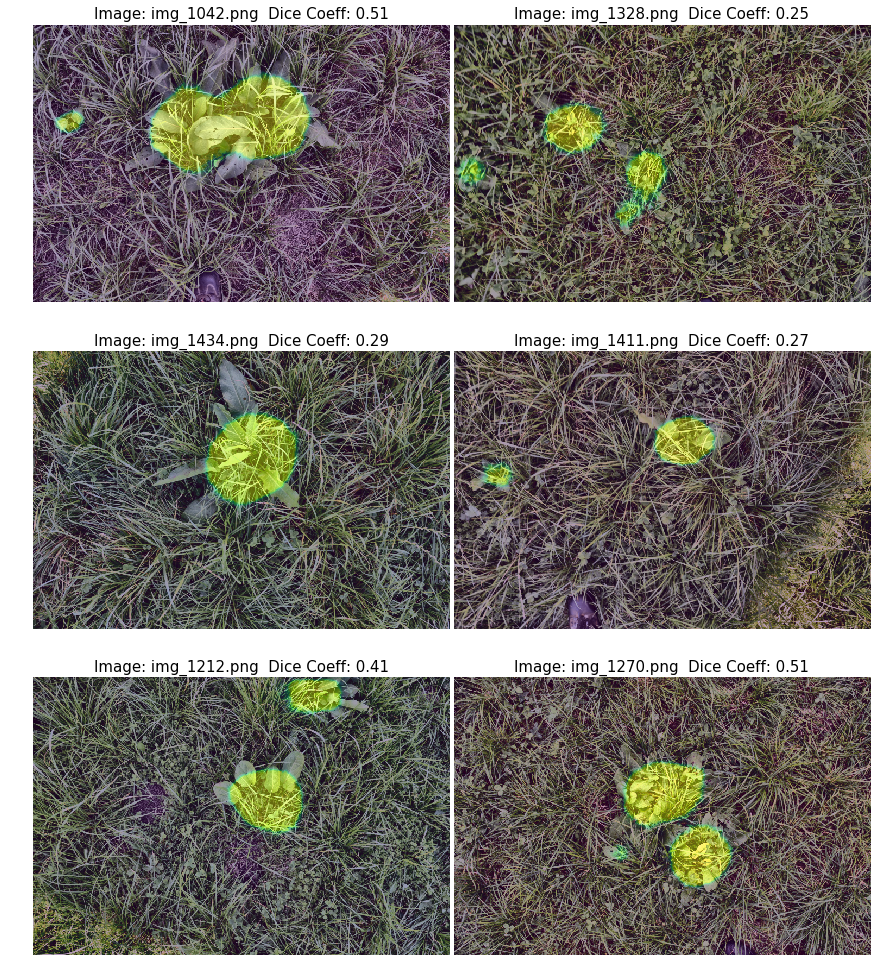

In [61]:
visualize.show_matrix(index='random',mode='image_prediction',rows=3)

In [19]:
#H2 = H

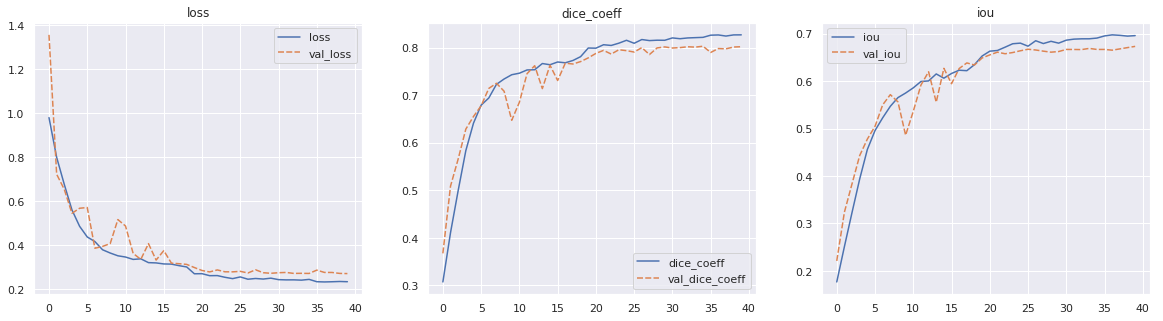

In [63]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
data = {#"epochs":np.linspace(0,len(H.history['dice_coeff']),len(H.history['dice_coeff'])),
        "loss":H2.history['loss'],
        "val_loss":H2.history['val_loss']}
loss_data = pd.DataFrame.from_dict(data)
sns.set(style="darkgrid")
ax = sns.lineplot(data=loss_data).set_title("loss")

plt.subplot(1,3,2)
data = {#"epochs":np.linspace(0,len(H.history['dice_coeff']),len(H.history['dice_coeff'])),
        "dice_coeff":H2.history['dice_coeff'],
        "val_dice_coeff":H2.history['val_dice_coeff']}
dice_data = pd.DataFrame.from_dict(data)
sns.set(style="darkgrid")
ax = sns.lineplot(data=dice_data).set_title("dice_coeff")

plt.subplot(1,3,3)
data = {#"epochs":np.linspace(0,len(H.history['dice_coeff']),len(H.history['dice_coeff'])),
        "iou":H2.history['iou_score'],
        "val_iou":H2.history['val_iou_score']}
iou_data = pd.DataFrame.from_dict(data)
sns.set(style="darkgrid")
ax = sns.lineplot(data=iou_data).set_title("iou")

In [64]:
model.save('unet_vgg19_dice_0.8017_iou_0.6732.h5')

In [65]:
loss_data.to_pickle("loss_data_df_unet_vgg19_dice_0.8017_iou_0.6732")
dice_data.to_pickle("dice_data_df_unet_vgg19_dice_0.8017_iou_0.6732")
iou_data.to_pickle("iou_data_df_unet_vgg19_dice_0.8017_iou_0.6732")

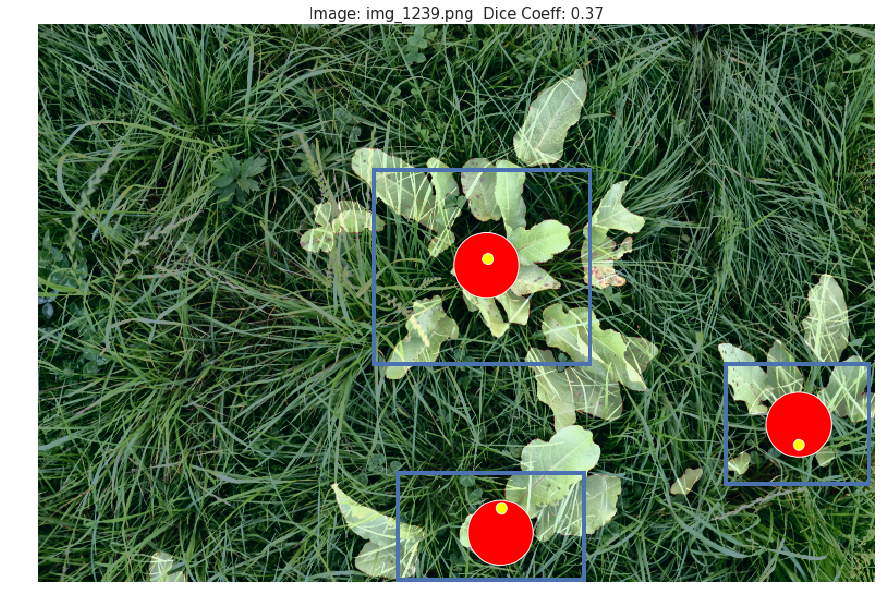

In [101]:
vis_params = {'df':val_df,
              'input_shape':(512,768,3),
              'pred_layer':2,
              'model':model}

root_pred = Visualize(**vis_params)
#img_1114
root_pred.show_single("img_1239",mode="image_prediction_roots")

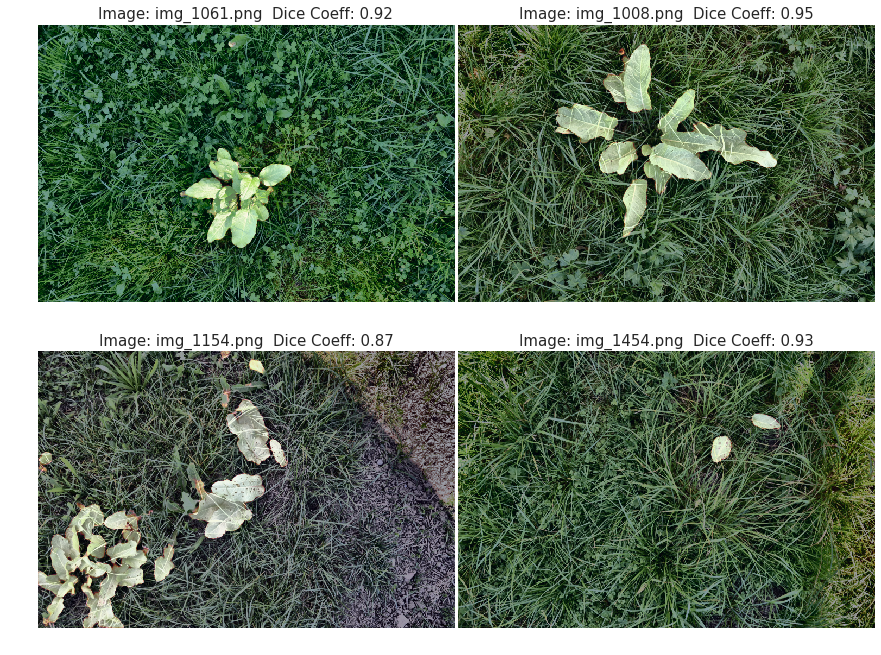

In [91]:
root_pred.show_matrix('random',mode="image_prediction_roots",rows=2)

### 3.7 Visualize Error Mask

In [76]:
ev_params = {'df':val_df,
             'input_shape':(512,768,3),
             'pred_layer' : 1,
             'model':model}
ev = Evaluate(**ev_params)

Aufsummiern aller falsch detektieren Masken (False Positive + False Negative):

In [77]:
def predict_all_error(df):
    error_sum = np.zeros(SHAPE)
    for i, row in df.iterrows():
        err = ev.get_full_error_mask(index=row['name'])
        error_sum += err
    return error_sum

In [79]:
summed_mask_error = predict_all_error(val_df)

Visualisierung aller überlagerten False Positiv + False Negativ Masken:

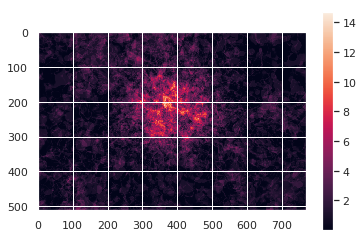

In [81]:
imshow(summed_mask_error)
plt.colorbar()

In [83]:
summed_mask_train = np.zeros((1024,1536))
for i,row in val_df.iterrows():
    summed_mask_train += rle_decode(row['mask_rle'],(1024,1536))
summed_mask_train = resize(summed_mask_train,(512,768))

Vergleich der summierten Trainingsmasken (Bild rechts) mit den summierten Falschen vorhersagen (Bild mitte). Das Bild rechts zeigt die subtraktion der normalisierten Trainingsmasken mit den normalisierten False Positiv + False Negativ:

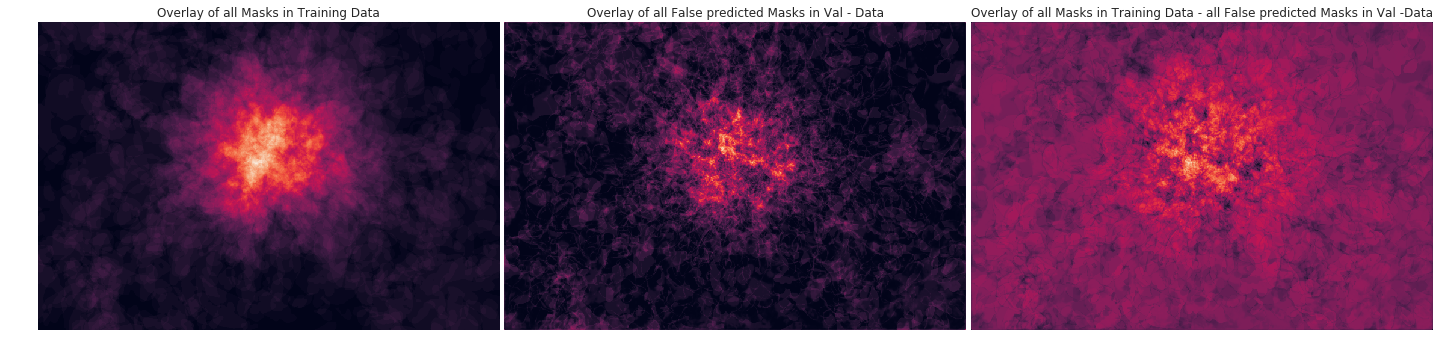

In [84]:
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=(25,18))
axs[0].imshow(summed_mask_train)
axs[1].imshow(summed_mask_error)
#axs[1,0].imshow(summed_mask_train-summed_mask_error)
axs[2].imshow(summed_mask_train/summed_mask_train.max()-summed_mask_error/summed_mask_error.max())
axs[0].set_title('Overlay of all Masks in Training Data')
axs[0].axis('off')
axs[1].set_title('Overlay of all False predicted Masks in Val - Data')
axs[1].axis('off')
axs[2].set_title('Overlay of all Masks in Training Data - all False predicted Masks in Val -Data')
axs[2].axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0)

Die meisten falsch vohergesagten Masken befinden sich zwar im Zentrum der Bilder (wie die meisten Masken in den Trainingsbildern), jedoch sind diese besser Verteilt als die Ground Truth Masken. (Die Farbskalierung der Bilder ist bei beiden gleich) 
Daraus schliesse ich, das sich die Anhäufung der GroundTruth- Masken in den Trainingsdaten im Zentrum, negativ auf die vorhersagen von Blacken im Randbereich asuwirkt. d.h. es werden im Randbereich der Bilder überdurchschnittlich viele Blacken falsch vorhergesagt.

<img src="../docs/notebook_images/False_negativ_positv.png">